In [1]:
import requests
import pandas as pd 
import datetime as dt
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import math
from tqdm import tqdm

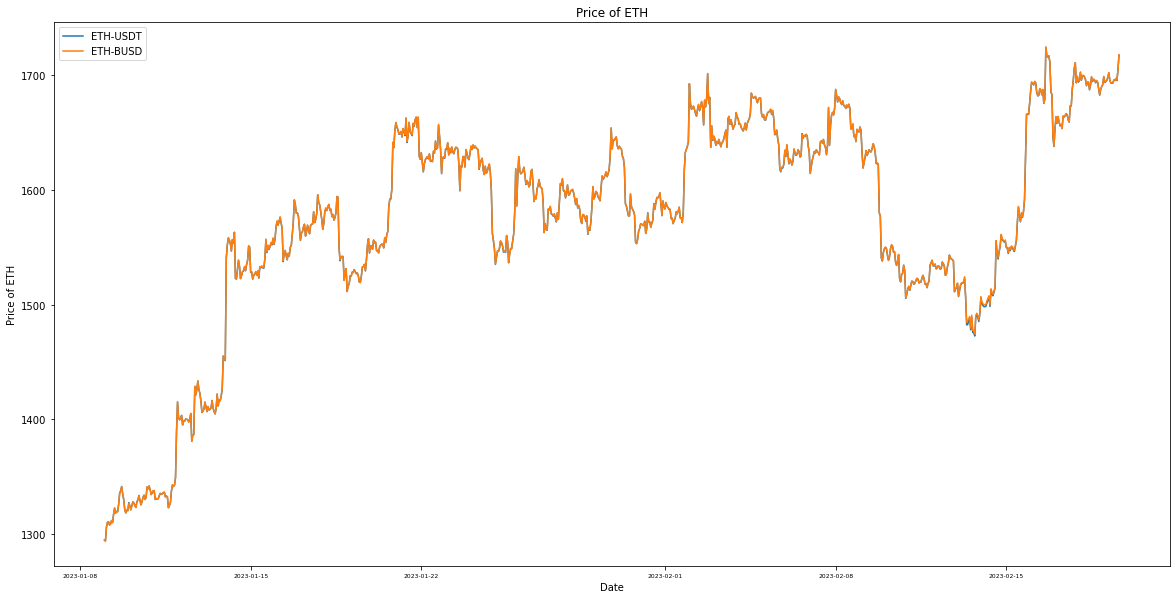

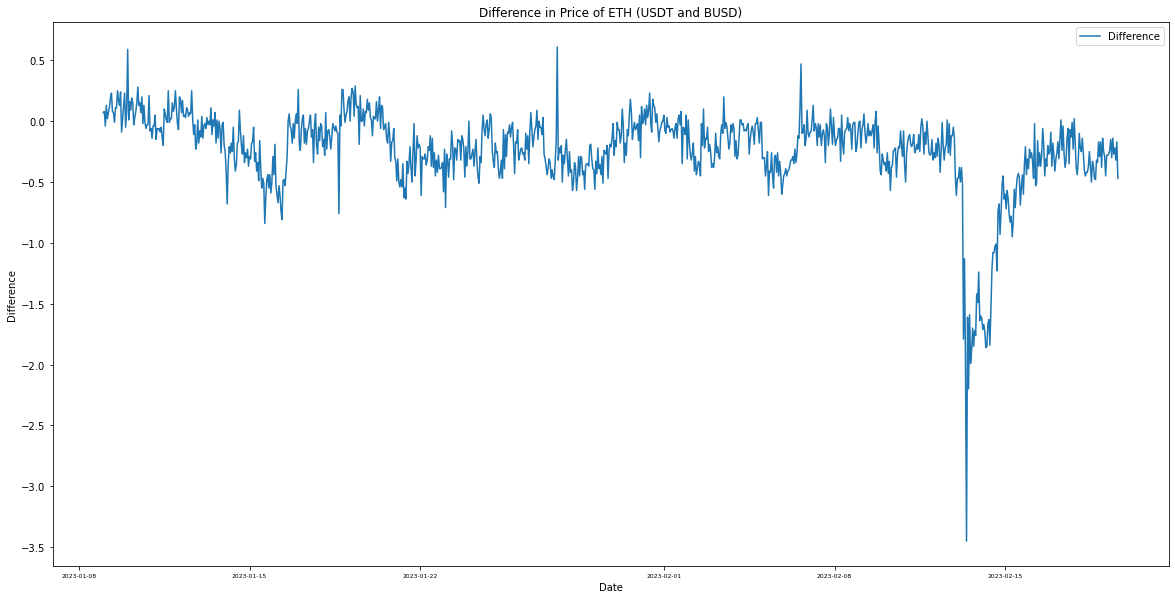

In [2]:
binance_link_usdt = 'https://api.binance.com/api/v3/klines?symbol=ETHUSDT&interval=1h&limit=1000'
binance_link_busd = 'https://api.binance.com/api/v3/klines?symbol=ETHBUSD&interval=1h&limit=1000'

data_usdt = pd.DataFrame(requests.get(binance_link_usdt).json())[[0,4]]
data_usdt.columns=['Time', 'Close_Price_USDT']
data_usdt.Time = data_usdt.Time.apply(lambda x: dt.datetime.utcfromtimestamp(int(x)/1000))

data_busd = pd.DataFrame(requests.get(binance_link_busd).json())[[0,4]]
data_busd.columns=['Time', 'Close_Price_BUSD']
data_busd.Time = data_busd.Time.apply(lambda x: dt.datetime.utcfromtimestamp(int(x)/1000))

combined_df = pd.merge(data_usdt, data_busd, on = 'Time')

fig = plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(combined_df['Time']), combined_df['Close_Price_USDT'].astype(float), label = 'ETH-USDT')
plt.plot(pd.to_datetime(combined_df['Time']), combined_df['Close_Price_BUSD'].astype(float), label = 'ETH-BUSD')
plt.xlabel('Date')
plt.legend()
plt.xticks(fontsize=6 ) 
plt.ylabel('Price of ETH')
plt.title("Price of ETH")
plt.show()

fig = plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(combined_df['Time']), combined_df['Close_Price_USDT'].astype(float) - combined_df['Close_Price_BUSD'].astype(float), label = 'Difference')
plt.xlabel('Date')
plt.legend()
plt.xticks(fontsize=6 ) 
plt.ylabel('Difference')
plt.title("Difference in Price of ETH (USDT and BUSD)")
plt.show()

As there is an insignificant difference in price in ETH when denominated in USDT and BUSD, we will assume USDT and BUSD essentially trade at a parity of 1:1 and choose USDT as the base asset given the higher volume recorded.

# ETH-USDT

In [3]:
#getting the data from binance api - using USDT 

binance_link = 'https://api.binance.com/api/v3/klines?symbol=ETHUSDT&interval=1h&limit=1000'

data = pd.DataFrame(requests.get(binance_link).json())[[0,4]]
data.columns=['Time', 'Close_Price']
data.Time = data.Time.apply(lambda x: dt.datetime.utcfromtimestamp(int(x)/1000))
data

,Time,Close_Price
0,2023-01-09 00:00:00,1294.86000000
1,2023-01-09 01:00:00,1294.02000000
2,2023-01-09 02:00:00,1306.16000000
3,2023-01-09 03:00:00,1310.37000000
4,2023-01-09 04:00:00,1310.86000000
...,...,...
995,2023-02-19 11:00:00,1695.36000000
996,2023-02-19 12:00:00,1696.99000000
997,2023-02-19 13:00:00,1695.20000000
998,2023-02-19 14:00:00,1704.44000000


In [4]:
pip install ccxt

Note: you may need to restart the kernel to use updated packages.


In [5]:
link = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/USDT&period=1h'
data_usdt = pd.DataFrame(requests.get(link).json())[[0, 4]]
data_usdt = data_usdt.rename(columns={0:'Time', 4: 'Close_Price_USDT'})
data_usdt.Time = data_usdt.Time.astype(int)
data_usdt.Time = data_usdt.Time.apply(lambda x: dt.datetime.utcfromtimestamp(int(x/1000)))

link = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/BUSD&period=1h'
data_busd = pd.DataFrame(requests.get(link).json())[[0, 4]]
data_busd = data_busd.rename(columns={0:'Time', 4: 'Close_Price_BUSD'})
data_busd.Time = data_busd.Time.astype(int)
data_busd.Time = data_busd.Time.apply(lambda x: dt.datetime.utcfromtimestamp(int(x/1000)))

combined_df = pd.merge(data_busd, data_usdt, on = 'Time')

In [6]:

data = data_usdt.copy().rename(columns={'Close_Price_USDT':'Close_Price'})

In [7]:
len(data_usdt)

1000

Text(0.5, 1.0, 'Price of ETH (USDT)')

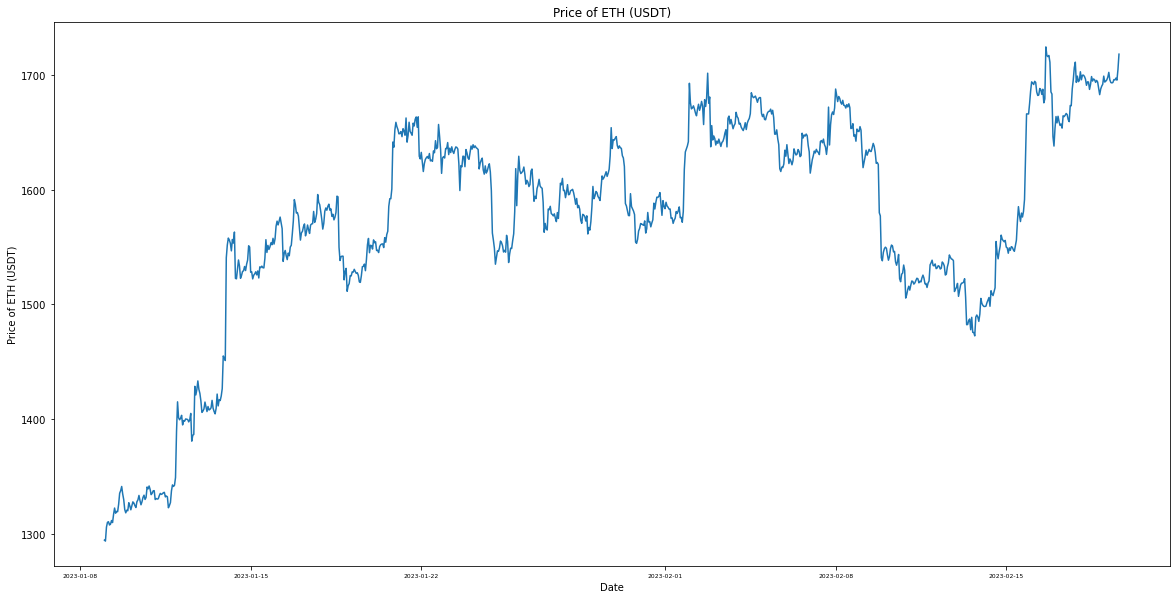

In [8]:
fig = plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(data['Time']), data['Close_Price'].astype(float))
plt.xlabel('Date')
plt.xticks(fontsize=6 ) 
plt.ylabel('Price of ETH (USDT)')
plt.title("Price of ETH (USDT)")

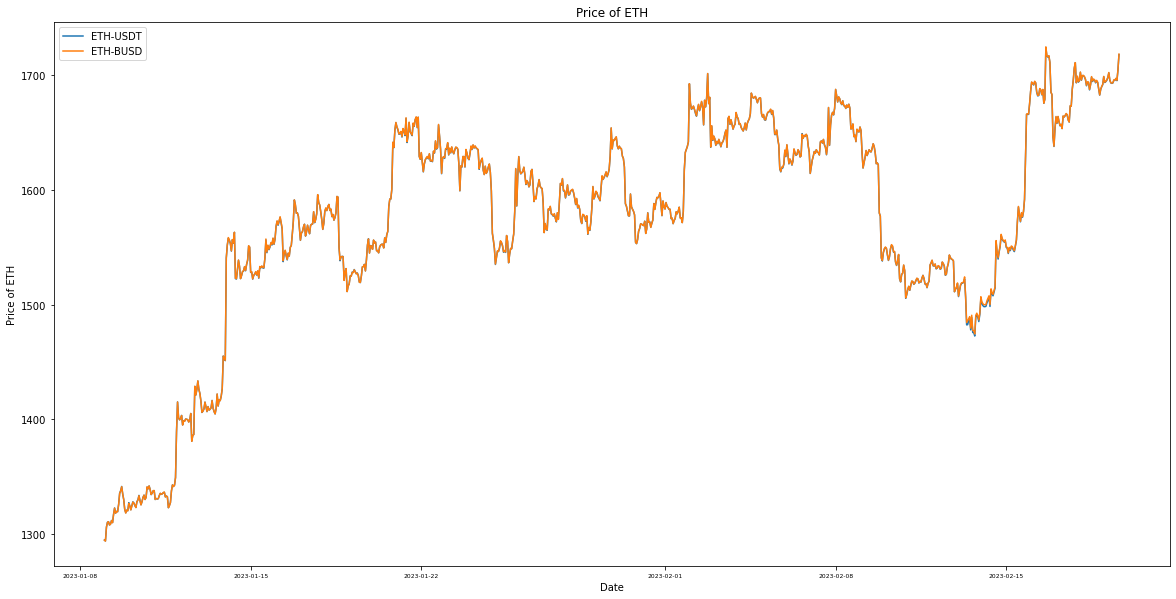

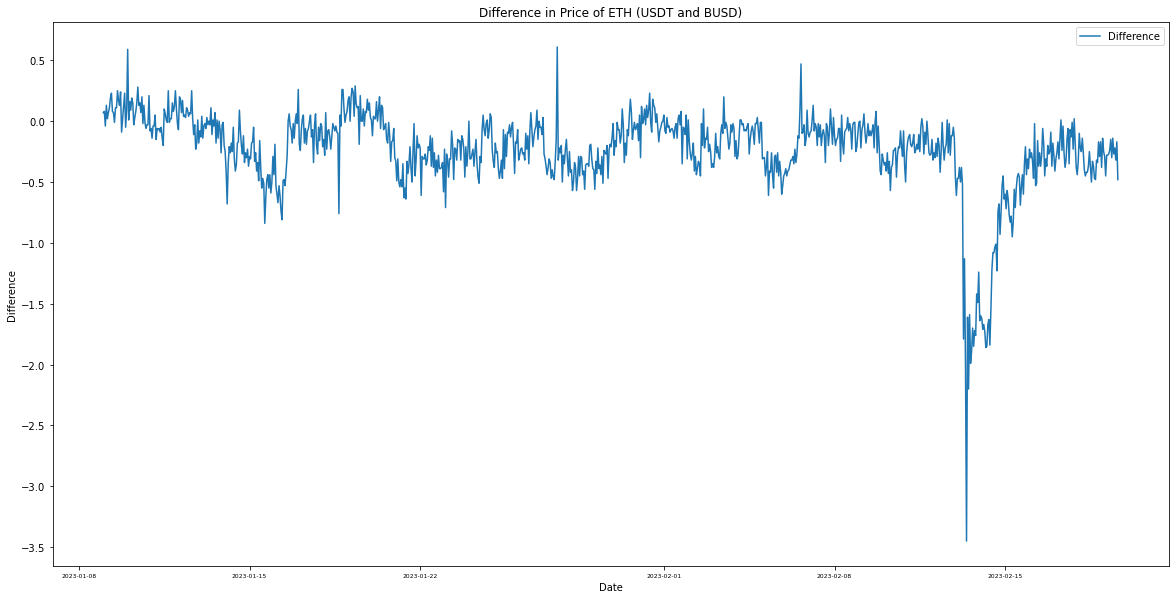

In [9]:

fig = plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(combined_df['Time']), combined_df['Close_Price_USDT'].astype(float), label = 'ETH-USDT')
plt.plot(pd.to_datetime(combined_df['Time']), combined_df['Close_Price_BUSD'].astype(float), label = 'ETH-BUSD')
plt.xlabel('Date')
plt.legend()
plt.xticks(fontsize=6 ) 
plt.ylabel('Price of ETH')
plt.title("Price of ETH")
plt.show()

fig = plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(combined_df['Time']), combined_df['Close_Price_USDT'].astype(float) - combined_df['Close_Price_BUSD'].astype(float), label = 'Difference')
plt.xlabel('Date')
plt.legend()
plt.xticks(fontsize=6 ) 
plt.ylabel('Difference')
plt.title("Difference in Price of ETH (USDT and BUSD)")
plt.show()

# Data Preprocessing

Get a rolling average of the mean and standard deviation throughout as data will be scaled to account for anomalies

In [10]:
def get_mov_avg_std(df, col, N):

    mean_list = df[col].rolling(window = N, min_periods=1).mean() 
    std_list = df[col].rolling(window = N, min_periods=1).std()   
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

Introduce a lag of 5 hours to prevent a look ahead bias 


In [11]:
N= 5
shift_range = 5

for i in range(1, shift_range +1):
    data['lag_' + str(i)] = data['Close_Price'].shift(i)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data = get_mov_avg_std(data, 'Close_Price',N)
data

,Time,Close_Price,lag_1,lag_2,lag_3,lag_4,lag_5,Close_Price_mean,Close_Price_std
0,2023-01-09 05:00:00,1308.02,1310.86,1310.37,1306.16,1294.02,1294.86,NaN,NaN
1,2023-01-09 06:00:00,1308.80,1308.02,1310.86,1310.37,1306.16,1294.02,1308.020,NaN
2,2023-01-09 07:00:00,1311.92,1308.80,1308.02,1310.86,1310.37,1306.16,1308.410,0.551543
3,2023-01-09 08:00:00,1310.16,1311.92,1308.80,1308.02,1310.86,1310.37,1309.580,2.063686
4,2023-01-09 09:00:00,1317.25,1310.16,1311.92,1308.80,1308.02,1310.86,1309.725,1.709766
...,...,...,...,...,...,...,...,...,...
990,2023-02-19 11:00:00,1695.36,1695.68,1693.15,1692.82,1693.15,1695.46,1694.052,1.394443
991,2023-02-19 12:00:00,1696.99,1695.36,1695.68,1693.15,1692.82,1693.15,1694.032,1.369697
992,2023-02-19 13:00:00,1695.20,1696.99,1695.36,1695.68,1693.15,1692.82,1694.800,1.769675
993,2023-02-19 14:00:00,1704.44,1695.20,1696.99,1695.36,1695.68,1693.15,1695.276,1.381459


Splitting of data into train, val and test sets

In [12]:
train_size = 0.6 
test_size = 0.2                                              
val_size = 0.2                                                 
N = 5 #For time lag (to get previous hours of data)  

In [13]:
num_val = int(val_size*len(data))
num_test = int(test_size*len(data))
num_train = len(data) - num_val - num_test
print("num_train = " + str(num_train))
print("num_val = " + str(num_val))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = data[:num_train]
val = data[num_train:num_train+num_val]
train_val = data[:num_train+num_val]
test = data[num_train+num_val:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(val.shape))
print("train_cv.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

num_train = 597
num_val = 199
num_test = 199
train.shape = (597, 9)
cv.shape = (199, 9)
train_cv.shape = (796, 9)
test.shape = (199, 9)


In [14]:
train_time = train['Time']
test_time = test['Time']
val_time = val['Time']
train_val_time = train_val['Time']

train = train.drop(columns = ['Time'])
test = test.drop(columns = ['Time'])
val = val.drop(columns = ['Time'])
train_val = train_val.drop(columns = ['Time'])

feature_pool = train.columns
output = 'Close_Price'

In [15]:
print(train.isna().sum())
print(test.isna().sum())
print(val.isna().sum())
print(train_val.isna().sum())

Close_Price         0
lag_1               0
lag_2               0
lag_3               0
lag_4               0
lag_5               0
Close_Price_mean    1
Close_Price_std     2
dtype: int64
Close_Price         0
lag_1               0
lag_2               0
lag_3               0
lag_4               0
lag_5               0
Close_Price_mean    0
Close_Price_std     0
dtype: int64
Close_Price         0
lag_1               0
lag_2               0
lag_3               0
lag_4               0
lag_5               0
Close_Price_mean    0
Close_Price_std     0
dtype: int64
Close_Price         0
lag_1               0
lag_2               0
lag_3               0
lag_4               0
lag_5               0
Close_Price_mean    1
Close_Price_std     2
dtype: int64


Fillna() with the previous 5 rows of data, if any

In [16]:
KNN_miss_filling = KNNImputer(n_neighbors=5).fit(train)
train = pd.DataFrame(KNN_miss_filling.transform(train))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(test)
test = pd.DataFrame(KNN_miss_filling.transform(test))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(train_val)
train_val = pd.DataFrame(KNN_miss_filling.transform(train_val))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(val)
val = pd.DataFrame(KNN_miss_filling.transform(val))



In [17]:
train.columns = feature_pool
test.columns = feature_pool
train_val.columns = feature_pool
val.columns = feature_pool

Standardization is performed

In [18]:
standardized_features = ['Close_Price_mean', 'Close_Price_std', 'Close_Price']

for j in range(1, N+1):
    standardized_features.append("lag_"+ str(j))
    
non_standardized_features = list(set(train.columns)-set(standardized_features))
non_standardized_features

[]

In [19]:
feature_pool = data.columns[2:]

X_train = train[feature_pool]
y_train = train[output]
X_val = val[feature_pool]
y_val = val[output]
X_train_val = train_val[feature_pool]
y_train_val = train_val[output]
X_test = test[feature_pool]
y_test = test[output]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_val.shape = " + str(X_val.shape))
print("y_val.shape = " + str(y_val.shape))
print("X_train_val.shape = " + str(X_train_val.shape))
print("y_train_val.shape = " + str(y_train_val.shape))
print("X_sample.shape = " + str(X_test.shape))
print("y_sample.shape = " + str(y_test.shape))

X_train.shape = (597, 7)
y_train.shape = (597,)
X_val.shape = (199, 7)
y_val.shape = (199,)
X_train_val.shape = (796, 7)
y_train_val.shape = (796,)
X_sample.shape = (199, 7)
y_sample.shape = (199,)


In [20]:
# Get the scaler based on train set
scaler = preprocessing.MinMaxScaler().fit(train[standardized_features])

train_std=pd.DataFrame(scaler.fit_transform(train[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_nstd=pd.DataFrame(train[non_standardized_features])


train_std.columns = train_std.columns.map(lambda x: standardized_features[x])
train_std.reset_index(drop=True, inplace=True)
train_nstd.reset_index(drop=True, inplace=True)
train_scaled = pd.concat([train_std,train_nstd], sort=False,axis=1)

# Get the scaler based on cv set
scaler.val = preprocessing.MinMaxScaler().fit(val[standardized_features])


val_std=pd.DataFrame(scaler.transform(val[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
val_nstd=pd.DataFrame(val[non_standardized_features])
val_std.columns = val_std.columns.map(lambda x: standardized_features[x])
val_std.reset_index(drop=True, inplace=True)
val_nstd.reset_index(drop=True, inplace=True)
val_scaled = pd.concat([val_std,val_nstd], sort=False,axis=1)


scaler_trainval = preprocessing.MinMaxScaler().fit(train_val[standardized_features])


train_val_std=pd.DataFrame(scaler.transform(train_val[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_val_nstd=pd.DataFrame(train_val[non_standardized_features])
train_val_std.columns = train_val_std.columns.map(lambda x: standardized_features[x])
train_val_std.reset_index(drop=True, inplace=True)
train_val_nstd.reset_index(drop=True, inplace=True)
train_val_scaled = pd.concat([train_val_std,train_val_nstd], sort=False,axis=1)



scaler_test = preprocessing.MinMaxScaler().fit(test[standardized_features])


test_std=pd.DataFrame(scaler.transform(test[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
test_nstd=pd.DataFrame(test[non_standardized_features])
test_std.columns = test_std.columns.map(lambda x: standardized_features[x])
test_std.reset_index(drop=True, inplace=True)
test_nstd.reset_index(drop=True, inplace=True)
test_scaled = pd.concat([test_std,test_nstd], sort=False,axis=1)

In [21]:
X_train_scaled = train_scaled[feature_pool]
y_train_scaled = train_scaled['Close_Price']
X_val_scaled = val_scaled[feature_pool]
y_val_scaled= val_scaled['Close_Price']
X_train_val_scaled = train_val_scaled[feature_pool]
y_train_val_scaled = train_val_scaled['Close_Price']
X_test_scaled = test_scaled[feature_pool]
y_test_scaled = test_scaled['Close_Price']
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_val_scaled.shape = " + str(X_val_scaled.shape))
print("y_val_scaled.shape = " + str(y_val_scaled.shape))
print("X_train_val_scaled.shape = " + str(X_train_val_scaled.shape))
print("y_train_val_scaled.shape = " + str(y_train_val_scaled.shape))
print("X_test_scaled.shape = " + str(X_test_scaled.shape))
print("y_test_scaled.shape = " + str(y_test_scaled.shape))

X_train_scaled.shape = (597, 7)
y_train_scaled.shape = (597,)
X_val_scaled.shape = (199, 7)
y_val_scaled.shape = (199,)
X_train_val_scaled.shape = (796, 7)
y_train_val_scaled.shape = (796,)
X_test_scaled.shape = (199, 7)
y_test_scaled.shape = (199,)


In [22]:
X_train_scaled

,lag_1,lag_2,lag_3,lag_4,lag_5,Close_Price_mean,Close_Price_std
0,0.007222,0.005976,0.000000,0.000000,0.002063,0.003672,0.041309
1,0.000000,0.007222,0.010655,0.029810,0.000000,0.000000,0.041309
2,0.001983,0.000000,0.011895,0.040147,0.029810,0.001043,0.000000
3,0.009917,0.001983,0.004708,0.041351,0.040147,0.004173,0.028343
4,0.005442,0.009917,0.006682,0.034377,0.041351,0.004561,0.021709
...,...,...,...,...,...,...,...
592,0.947260,0.933579,1.000000,0.948214,0.928815,1.000000,0.202989
593,0.837050,0.947260,0.933892,1.000000,0.948214,0.981228,0.426939
594,0.883967,0.837050,0.947508,0.935862,1.000000,0.968101,0.448584
595,0.852130,0.883967,0.837817,0.949073,0.935862,0.936993,0.347909


# XGBoost Model

In [23]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Error metrics used - MAPE, RMSE. This will be used for hyper parameter tuning

In [24]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def get_rmse(y_true, y_pred): 
    return math.sqrt(mean_squared_error(y_true, y_pred))

def get_nmse(y, yhat) -> float:
    assert len(y) == len(yhat)
    mse_xy = np.sum(np.square(np.asarray(y) - np.asarray(yhat)))
    mse_x = np.sum(np.square(np.asarray(y)))
    nmse = mse_xy / mse_x
    return nmse

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed, \
                          n_estimators, \
                          max_depth, \
                          learning_rate, \
                          min_child_weight, \
                          subsample, \
                          colsample_bytree, \
                          colsample_bylevel, \
                          gamma):

    model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    

    model.fit(X_train_scaled, y_train_scaled)
    
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [25]:
#default params
n_estimators = 100                         
max_depth = 3                               
learning_rate = 0.1                         
min_child_weight = 1                  
subsample = 1                  
colsample_bytree = 1           
colsample_bylevel = 1          
gamma = 0                      
model_seed = 100

In [26]:
#Using the default parameters, test on train scaled and evaluate on validation scaled 

rmse_bef_tuning, mape_bef_tuning, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_Price_mean'],
                                     val['Close_Price_std'],
                                     seed = model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)


print("RMSE on val set = ",  round(rmse_bef_tuning, 3) ) 
print("MAPE on val set = ",  round(mape_bef_tuning, 3) ) 


RMSE on val set =  14.931
MAPE on val set =  0.006


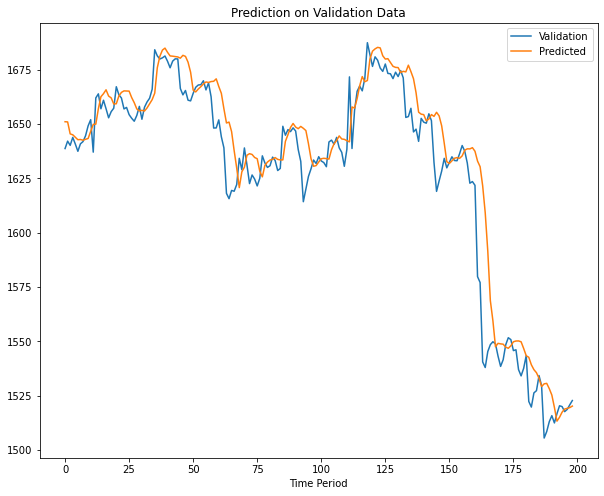

In [27]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

plt.plot(val['Close_Price'], label = 'Validation') 
plt.plot(pred, label='Predicted')
plt.title("Prediction on Validation Data")
plt.xlabel("Time Period")
plt.legend()

In [28]:
param_label = 'n_estimators'
param_list = range(10, 100, 5)

param2_label = 'max_depth'
param2_list = [1, 2,3, 4, 5, 6, 7, 8, 9, 10]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}


for param in param_list:    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_Price_mean'],
                                     val['Close_Price_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3) ) 
print("optimum params = ", n_estimators_opt, max_depth_opt)

min RMSE =  14.512
optimum params =  10 1


In [29]:
param_label = 'learning_rate'
param_list = list(np.arange(0.01, 1, 0.01)) 


param2_label = 'min_child_weight'
param2_list = range(1, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):
    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                    y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_Price_mean'],
                                     val['Close_Price_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = ", error_rate['rmse'].min())
print("optimum params = ",
learning_rate_opt, min_child_weight_opt)
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ", 
temp['learning_rate'].values[0], temp['min_child_weight'].values[0])

min RMSE =  13.964048230134418
optimum params =  0.01 1
min MAPE =  0.005
optimum params =  0.01 1


In [30]:
param_label = 'subsample'
param_list = list(np.arange(0.1, 1, 0.1))  

param2_label = 'gamma'
param2_list = list(np.arange(0.01, 1, 0.01))  
error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_Price_mean'],
                                     val['Close_Price_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3))
print("optimum params = ",
subsample_opt, gamma_opt)
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ",
temp['subsample'].values[0], temp['gamma'].values[0])

min RMSE =  13.964
optimum params =  0.5 0.01
min MAPE =  0.005
optimum params =  0.5 0.01


In [31]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_Price_mean'],
                                     val['Close_Price_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3))
print("optimum params = ", colsample_bytree_opt, colsample_bylevel_opt) 
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ",
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0])


min RMSE =  13.956
optimum params =  0.5 0.5
min MAPE =  0.005
optimum params =  0.5 0.5


In [32]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params
tuned_params

,param,original,after_tuning
0,n_estimators,100.000000,10.000000
1,max_depth,3.000000,1.000000
2,learning_rate,0.100000,0.010000
3,min_child_weight,1.000000,1.000000
4,subsample,1.000000,0.500000
5,colsample_bytree,1.000000,0.500000
6,colsample_bylevel,1.000000,0.500000
7,gamma,0.000000,0.010000
8,rmse,14.931330,13.956443
9,mape,0.005856,0.005427


# Prediction

In [33]:
'''model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

model.fit(X_train_val_scaled, y_train_val_scaled)
    
est_scaled = model.predict(X_test_scaled)
est = est_scaled * test['Close_Price_mean'] +    test['Close_Price_std']
est'''

"model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,\n                         n_estimators=n_estimators_opt, \n                             max_depth=max_depth_opt, \n                             learning_rate=learning_rate_opt, \n                             min_child_weight=min_child_weight_opt, \n                             subsample=subsample_opt, \n                             colsample_bytree=colsample_bytree_opt, \n                             colsample_bylevel=colsample_bylevel_opt, \n                             gamma=gamma_opt)\n\nmodel.fit(X_train_val_scaled, y_train_val_scaled)\n    \nest_scaled = model.predict(X_test_scaled)\nest = est_scaled * test['Close_Price_mean'] +    test['Close_Price_std']\nest"

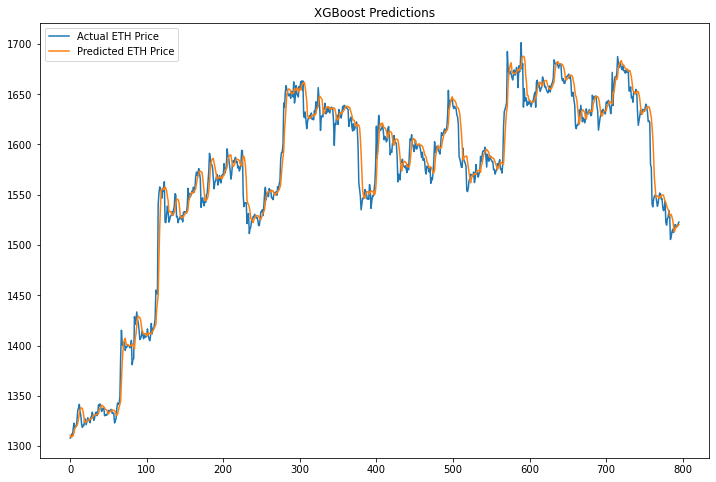

In [34]:
#insample prediction 

model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

model.fit(X_train_val_scaled, y_train_val_scaled)
    
    
est_scaled = model.predict(X_train_val_scaled)
pred_vals = est_scaled * train_val['Close_Price_std'] +    train_val['Close_Price_mean']
actual_vals = train_val['Close_Price']
plt.figure(figsize=(12,8))
plt.plot(actual_vals, label='Actual ETH Price')
plt.plot(pred_vals, label='Predicted ETH Price')
plt.title('XGBoost Predictions')
plt.legend()
plt.show()

In [35]:
get_rmse(actual_vals, pred_vals), get_mape(actual_vals, pred_vals)*100, get_nmse(actual_vals, pred_vals)

(14.545428714385647, 0.5914932535102675, 8.586990558432065e-05)

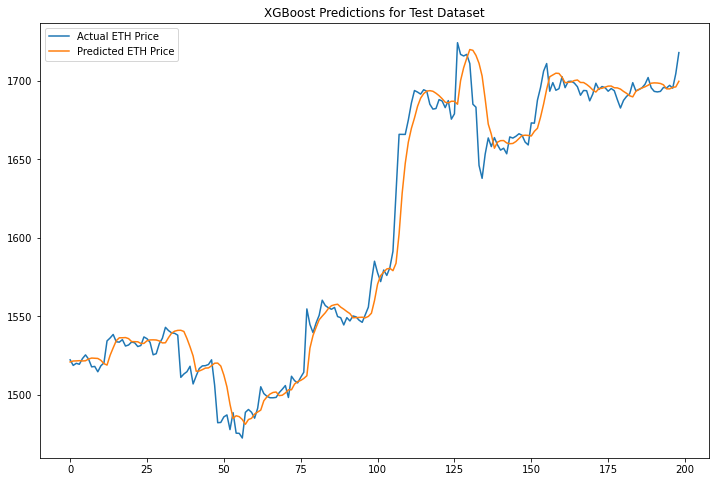

In [36]:
#outsample prediction 

model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

model.fit(X_train_val_scaled, y_train_val_scaled)
    
    
est_scaled = model.predict(X_test_scaled)
pred_vals = est_scaled * test['Close_Price_std'] +    test['Close_Price_mean']
actual_vals = test['Close_Price']
plt.figure(figsize=(12,8))
plt.plot(actual_vals, label='Actual ETH Price')
plt.plot(pred_vals, label='Predicted ETH Price')
plt.title('XGBoost Predictions for Test Dataset')
plt.legend()
plt.show()

In [37]:
get_rmse(actual_vals, pred_vals), get_mape(actual_vals, pred_vals)*100, get_nmse(actual_vals, pred_vals)

(13.970530895707698, 0.5228060083021075, 7.595422576521904e-05)

Using the last 12 rows of data, we predict the next 12 rows == 12 hours of price data

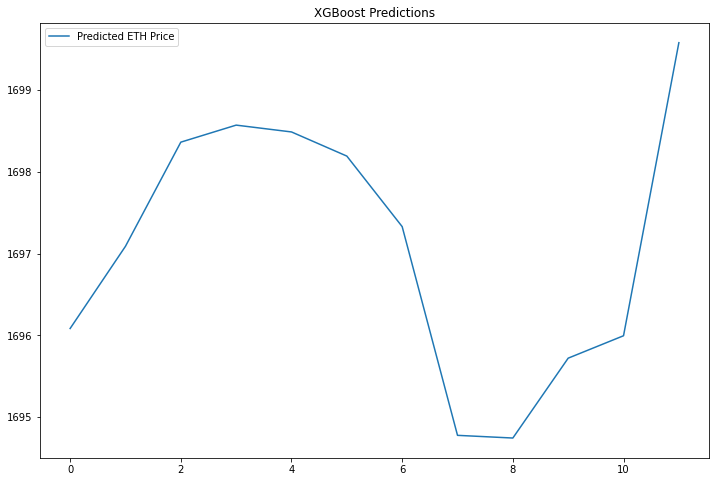

In [38]:
model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)
model.fit(X_train_val_scaled, y_train_val_scaled)

est_scaled = model.predict(X_test_scaled[-12:])
pred_vals = est_scaled * test[-12:]['Close_Price_std'].reset_index(drop=True) +    test[-12:]['Close_Price_mean'].reset_index(drop=True)
plt.figure(figsize=(12,8))
plt.plot(pred_vals, label='Predicted ETH Price')
plt.title('XGBoost Predictions')
plt.legend()
plt.show()

# Using Ocean Protocol's Checklist

In [39]:
# imports
import datetime
from datetime import timezone
import os
from pathlib import Path
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
def to_unixtime(dt: datetime.datetime):
    # must account for timezone, otherwise it's off
    ut = dt.replace(tzinfo=timezone.utc).timestamp()
    dt2 = datetime.datetime.utcfromtimestamp(ut)  # to_datetime() approach
    assert dt2 == dt, f"dt: {dt}, dt2: {dt2}"
    return ut


def to_unixtimes(dts: list) -> list:
    return [to_unixtime(dt) for dt in dts]


def to_datetime(ut) -> datetime.datetime:
    dt = datetime.datetime.utcfromtimestamp(ut)
    ut2 = dt.replace(tzinfo=timezone.utc).timestamp()  # to_unixtime() approach
    assert ut2 == ut, f"ut: {ut}, ut2: {ut2}"
    return dt


def to_datetimes(uts: list) -> list:
    return [to_datetime(ut) for ut in uts]


def round_to_nearest_hour(dt: datetime.datetime) -> datetime.datetime:
    return dt.replace(
        second=0, microsecond=0, minute=0, hour=dt.hour
    ) + datetime.timedelta(hours=dt.minute // 30)


def pretty_time(dt: datetime.datetime) -> str:
    return dt.strftime("%Y/%m/%d, %H:%M:%S")


def print_datetime_info(descr: str, uts: list):
    dts = to_datetimes(uts)
    print(descr + ":")
    print(f"  starts on: {pretty_time(dts[0])}")
    print(f"    ends on: {pretty_time(dts[-1])}")
    print(f"  {len(dts)} datapoints")
    print(f"  time interval between datapoints: {(dts[1]-dts[0])}")


def target_12h_unixtimes(start_dt: datetime.datetime) -> list:
    target_dts = [start_dt + datetime.timedelta(hours=h) for h in range(12)]
    target_uts = to_unixtimes(target_dts)
    return target_uts


# helper-functions: higher level
def load_from_ohlc_data(file_name: str) -> tuple:
    """Returns (list_of_unixtimes, list_of_close_prices)"""
    with open(file_name, "r") as file:
        data_str = file.read().rstrip().replace('"', "")
    x = eval(data_str)  # list of lists
    uts = [xi[0] / 1000 for xi in x]
    vals = [xi[4] for xi in x]
    return (uts, vals)


def filter_to_target_uts(
    target_uts: list, unfiltered_uts: list, unfiltered_vals: list
) -> list:
    """Return filtered_vals -- values at at the target timestamps"""
    filtered_vals = [None] * len(target_uts)
    for i, target_ut in enumerate(target_uts):
        time_diffs = np.abs(np.asarray(unfiltered_uts) - target_ut)
        tol_s = 1  # should always align within e.g. 1 second
        target_ut_s = pretty_time(to_datetime(target_ut))
        assert (
            min(time_diffs) <= tol_s
        ), f"Unfiltered times is missing target time: {target_ut_s}"
        j = np.argmin(time_diffs)
        filtered_vals[i] = unfiltered_vals[j]
    return filtered_vals


# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))


def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_


# helpers: prediction performance
def calc_nmse(y, yhat) -> float:
    assert len(y) == len(yhat)
    mse_xy = np.sum(np.square(np.asarray(y) - np.asarray(yhat)))
    mse_x = np.sum(np.square(np.asarray(y)))
    nmse = mse_xy / mse_x
    return nmse


def plot_prices(cex_vals, pred_vals):
    matplotlib.rcParams.update({"font.size": 22})
    x = [h for h in range(0, 12)]
    assert len(x) == len(cex_vals) == len(pred_vals)
    fig, ax = plt.subplots()
    ax.plot(x, cex_vals, "--", label="CEX values")
    ax.plot(x, pred_vals, "-", label="Pred. values")
    ax.legend(loc="lower right")
    plt.ylabel("ETH price")
    plt.xlabel("Hour")
    fig.set_size_inches(18, 18)
    plt.xticks(x)
    plt.show()

target times:
  starts on: 2023/02/18, 23:00:00
    ends on: 2023/02/19, 10:00:00
  12 datapoints
  time interval between datapoints: 1:00:00
allcex times:
  starts on: 2023/01/29, 20:00:00
    ends on: 2023/02/19, 15:00:00
  500 datapoints
  time interval between datapoints: 1:00:00
[1691.62, 1698.71, 1693.53, 1694.3, 1695.42, 1697.72, 1701.98, 1695.46, 1693.15, 1692.82, 1693.15, 1695.68]
NMSE = 3.771685597639705e-06


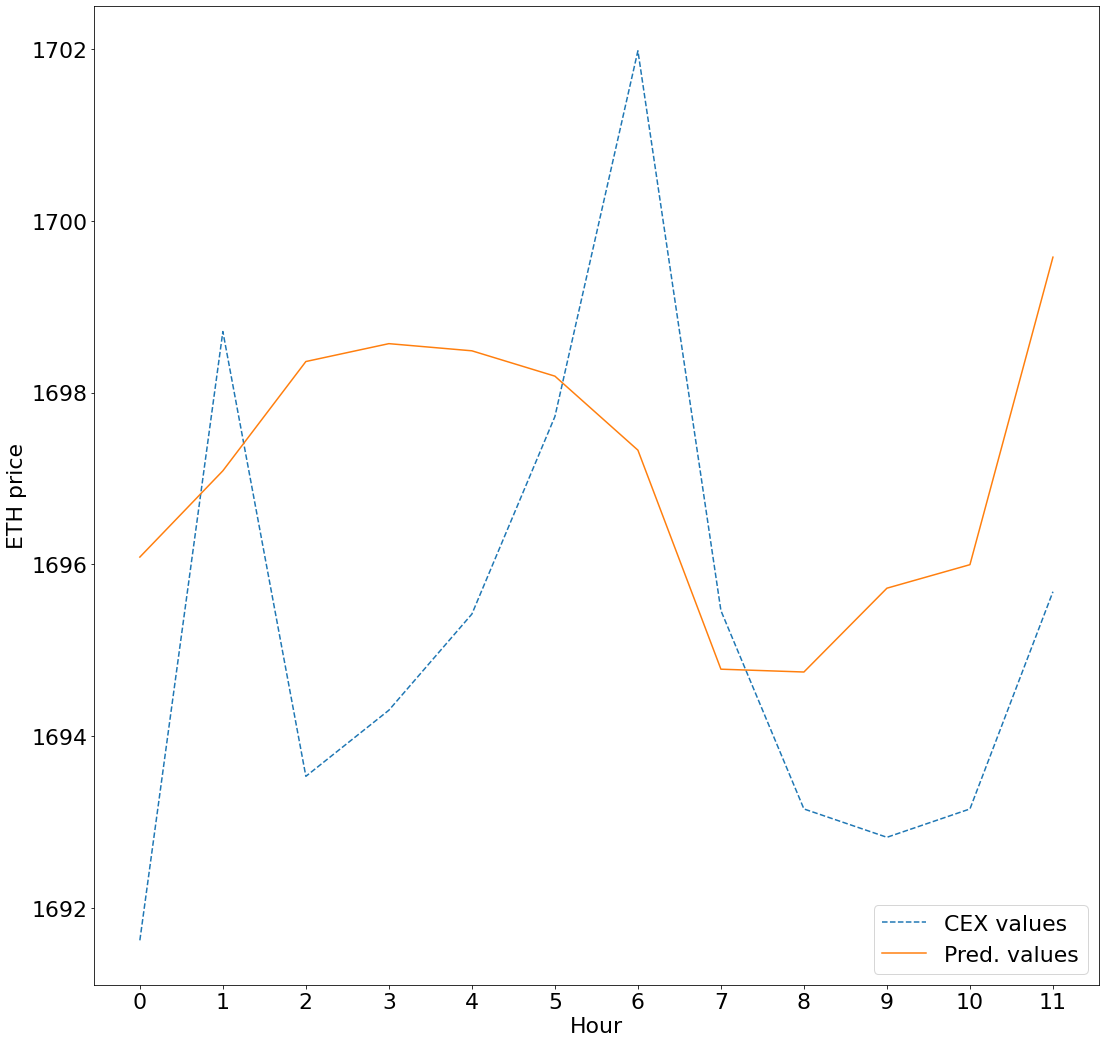

In [40]:
import datetime 
# get the time range we want to test for
start_dt = datetime.datetime.now() - datetime.timedelta(hours=24) #must be >= 12h ago
start_dt = round_to_nearest_hour(start_dt) # so that times line up
target_uts = target_12h_unixtimes(start_dt)
print_datetime_info("target times", target_uts)

# get the actual ETH values at that time
import ccxt
allcex_x = ccxt.binance().fetch_ohlcv('ETH/USDT', '1h')
allcex_uts = [xi[0]/1000 for xi in allcex_x]
allcex_vals = [xi[4] for xi in allcex_x]
print_datetime_info("allcex times", allcex_uts)

cex_vals = filter_to_target_uts(target_uts, allcex_uts, allcex_vals)

print(cex_vals)
# now, we have predicted and actual values. Let's find error, and plot!
nmse = calc_nmse(cex_vals, pred_vals)
print(f"NMSE = {nmse}")
plot_prices(cex_vals, pred_vals)